<a href="https://colab.research.google.com/github/eugeneyan/visualizing-finetunes/blob/main/3_ft_usb_then_fib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Aug 10 08:11:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:3D:00.0 Off |                  Off |
| 30%   32C    P8              20W / 230W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# %pip install -q transformers==4.37.2 accelerate bitsandbytes datasets peft watermark

In [4]:
%load_ext watermark
%watermark --conda -p torch,transformers,peft,datasets,sklearn

torch       : 2.3.1+cu121
transformers: 4.43.1
peft        : 0.11.1
datasets    : 2.19.1
sklearn     : 1.2.2

conda environment: n/a



In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import transformers
import time
import logging
import warnings
import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Trainer,
    BartForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    IntervalStrategy,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from typing import Dict, Optional, List
from sklearn.metrics import (average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.exceptions import UndefinedMetricWarning

In [6]:
# Set up logger
logger = logging.getLogger('3-ft-usb-then-fib')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)

logger.info('Running notebook to finetune USB followed by FIB')

2024-08-06 00:26:51 - INFO - Running notebook to finetune USB followed by FIB


In [7]:
# Suppress undefined metric warning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
torch.manual_seed(505)

## Define model and tokenizer
- Note: Entailment = 2, Neutral = 1, Contradiction = 0
- https://huggingface.co/valhalla/distilbart-mnli-12-1

In [10]:
# Define model
# model_id = 'valhalla/distilbart-mnli-12-1'
# model_id = 'valhalla/distilbart-mnli-12-3'
# lora_model_id = 'lora-distilbart-mnli-12-3'

model_id = 'facebook/bart-large-mnli'
lora_model_id = 'lora-bart-large-mnli'

In [11]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

## Load FIB & USB data

In [12]:
# Test loading into dataset
fib_files = {'train': 'data/fib-train.csv',
             'val': 'data/fib-val.csv',
             'test': 'data/fib-test.csv'}

fib_ds = load_dataset('csv', data_files=fib_files)
fib_ds = fib_ds.select_columns(['input', 'list_choices', 'label'])
fib_ds = fib_ds.rename_column('input', 'premise').rename_column('list_choices', 'hypothesis')

logger.info(f"Label distribution - Train: {Counter(fib_ds['train']['label'])}, Val: {Counter(fib_ds['val']['label'])}, Test: {Counter(fib_ds['test']['label'])}")

2024-08-06 00:27:03 - INFO - Label distribution - Train: Counter({0: 350, 2: 350}), Val: Counter({0: 75, 2: 75}), Test: Counter({0: 75, 2: 75})


In [13]:
# Test loading into dataset
usb_files = {'train': 'data/usb-train.csv',
             'val': 'data/usb-val.csv'}

usb_ds = load_dataset('csv', data_files=usb_files)
usb_ds = usb_ds.select_columns(['source', 'summary_sent', 'label'])
usb_ds = usb_ds.rename_column('source', 'premise').rename_column('summary_sent', 'hypothesis')

logger.info(f"Label distribution - Train: {Counter(usb_ds['train']['label'])}, Val: {Counter(usb_ds['val']['label'])}")

2024-08-06 00:27:04 - INFO - Label distribution - Train: Counter({2: 2525, 0: 2525}), Val: Counter({2: 1334, 0: 1334})


## Note how USB has 6x the trainset of FIB, and can be increased another 3x if we mix in the valset

In [14]:
# Tokenize data in batch
def tokenize(row):
    return tokenizer(row['premise'], row['hypothesis'], truncation='only_first', padding='max_length', max_length=512)

fib_ds = fib_ds.map(tokenize, batched=True)
usb_ds = usb_ds.map(tokenize, batched=True)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
logger.info(f'FIB: {fib_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["attention_mask"]}')

In [ ]:
logger.info(f'USB: {usb_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["attention_mask"]}')

## Set up model

In [15]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=3  #| 10
EVAL_STEPS=40
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [16]:
bnb_config = BitsAndBytesConfig(
    # load_in_8bit=True,
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [17]:
# Load model
model = BartForSequenceClassification.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', num_labels=3)

2024-08-06 00:28:21 - WARNING - WARNING: BNB_CUDA_VERSION=121 environment variable detected; loading libbitsandbytes_cuda121.so.
This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

2024-08-06 00:28:21 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [18]:
# Configure lora
config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,  # Keep lora alpha constant (per https://arxiv.org/abs/2305.14314) as it is proportional to learning rate
    target_modules=['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2'],
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model.enable_input_require_grads()
model = get_peft_model(model, config)

In [19]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    trainable_prop = 100 * trainable_params / all_param

    logger.info(f"all params: {all_param:,} | trainable: {trainable_params:,} ({trainable_prop:.2f}%)")

print_trainable_parameters(model)

2024-08-06 00:32:03 - INFO - all params: 239,326,259 | trainable: 8,667,184 (3.62%)


In [20]:
# Preprocess only logits to save memory
def preprocess_logits_for_metrics(logits, labels):
    """
    Returns the probability of contradiction (aka factual inconsistency aka hallucination)
    """
    # Exclude dim = 1 on the logits, compute softmax, and get prob of the 0 label (i.e., contradiction)
    probs = F.softmax(logits[0][:, [0, 2]], dim=1)[:, 0]
    return probs


# Compute multiple metrics at once
def compute_metrics(eval_pred: transformers.EvalPrediction) -> Dict[str, float]:
    labels = eval_pred.label_ids
    probs = eval_pred.predictions
    probs_thresholded = np.where(probs >= 0.80, 1, 0)  # Assign score > 0.8 = 1 (aka contradiction)

    # Update labels so 2 (entailment) is now 0, and 0 (contradiction) is now 1 because we want to focus on the latter
    labels = np.where(labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    # Compute metrics
    pr_auc = average_precision_score(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    recall = recall_score(labels, probs_thresholded)
    precision = precision_score(labels, probs_thresholded)

    return {'prauc': pr_auc, 'rocauc': roc_auc, 'recall': recall, 'precision': precision}

In [21]:
# See updates needed: https://github.com/huggingface/transformers/issues/20565
# See Trainer implementation: https://github.com/huggingface/transformers/blob/v4.31.0/src/transformers/trainer.py#L225
class CustomTrainer(Trainer):

    def __init__(self, eval_before_train=True, *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.eval_before_train = eval_before_train

    def train(self, resume_from_checkpoint=None, trial=None, **kwargs):
        metrics = None
        if self.eval_before_train:
            self.state.global_step = 0
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        # ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    logger.info(f'Step 0 metrics: {metrics}')
                    for key, value in metrics.items():
                        self.log({key: value})
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)
            self.eval_before_train = False

        # Call the original train method
        super(CustomTrainer, self).train(resume_from_checkpoint, trial, **kwargs)

    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        multiple=False,
    ) -> Dict[str, float]:
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        eval_loop = self.prediction_loop if self.args.use_legacy_prediction_loop else self.evaluation_loop
        output = eval_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )

        total_batch_size = self.args.eval_batch_size * self.args.world_size

        self.log(output.metrics)

        # self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)
        if not multiple:
            self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)

        self._memory_tracker.stop_and_update_metrics(output.metrics)

        return output.metrics

    def _maybe_log_save_evaluate(self, tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss

            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

    def get_eval_dataloader(self, eval_dataset=None):
        if eval_dataset is None and isinstance(self.eval_dataset, dict):
            # handle dictionary of datasets logic here
            # for this example, let's just return the 'fib' dataset dataloader
            eval_dataset = self.eval_dataset['set']
        return super().get_eval_dataloader(eval_dataset)

In [22]:
# setup wandb environment variables
%env WANDB_ENTITY=jermyn
%env WANDB_PROJECT=ft_usb_fib

env: WANDB_ENTITY=jermyn
env: WANDB_PROJECT=ft_usb_fib


In [23]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='./checkpoints/bart-usb-only',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    eval_strategy='steps',
    eval_steps=EVAL_STEPS,
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='fib_rocauc',
    greater_is_better=True,
    load_best_model_at_end=True,
)

## Set up trainer to finetune on USB data
- Note: label = 0 is after edit/factual consistency; label = 1 is before edit/factual inconsistency
- https://github.com/kukrishna/usb/blob/master/dataset_creators/usb_fac.py#L83

In [24]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=usb_ds['train'],
#     eval_dataset=usb_ds['val'],
#     compute_metrics=compute_metrics,
#     preprocess_logits_for_metrics=preprocess_logits_for_metrics
# )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=usb_ds['train'],
    eval_dataset={'usb': usb_ds['val'], 'fib': fib_ds['val']},  # Custom trainer supports two eval datasets!
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    eval_before_train=True
)

## Check evals before finetuning

In [25]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

def visualize_preds(y, y_pred, model_name):
    df = pd.DataFrame({'label': y, 'pred_proba': y_pred})

    # Compute ROCAUC metrics
    rocauc = roc_auc_score(df['label'], df['pred_proba'])
    fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
    baseline = np.sum(df['label']) / len(df)

    # Compute PRAUC metrics
    prauc = average_precision_score(df['label'], df['pred_proba'])
    prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

    # Split into consistent and inconsistent for prob distribution
    inconsistent = df[df['label'] == 1].reset_index(drop=True)
    consistent = df[df['label'] == 0].reset_index(drop=True)
    js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

    # Set up plots
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(13, 3), tight_layout=True)
    title_font_size = 10
    fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

    # Plot ROC
    ax0.grid()
    ax0.plot(fpr, tpr, label='ROC')
    ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
    ax0.set_xlabel('False positive rate')
    ax0.set_ylabel('True positive rate')
    ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
    ax0.legend()

    # Plot PRAUC
    ax1.grid()
    ax1.plot(rec, prec, label='PRAUC')
    ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim((-0.1, 1.1))
    ax1.set_ylim((-0.1, 1.1))
    ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot Precision & Recall
    ax2.grid()
    ax2.plot(thresholds, prec[1:], color='red', label='Precision')
    ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
    ax2.invert_xaxis()
    ax2.set_xlabel('Thresholds (1.0 - 0.0)')
    ax2.set_ylabel('Precision / Recall')
    ax2.set_xlim((1.1, -0.1))
    ax2.set_ylim((-0.1, 1.1))
    ax2.legend()
    ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot prob distribution
    ax3.grid()
    ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.set_xlabel('Prob of inconsistent')
    ax3.set_ylabel('Density')
    ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
    ax3.legend()

    plt.show()


def compute_metrics_per_threshold(y, y_pred, thresholds=[0.95, 0.90, 0.95, 0.80, 0.75, 0.70, 0.65, 0.60]):
    for threshold in thresholds:
        preds = (y_pred >= threshold).astype(int)

        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        logger.info(f'Threshold: {threshold:.2f} - Recall: {recall:.2f}, Precision: {precision:.2f}')

[2024-08-05 00:52:45,732] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2024-08-05 00:52:45 - INFO - gcc -pthread -B /root/miniconda3/envs/py3.11/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /root/miniconda3/envs/py3.11/include -fPIC -O2 -isystem /root/miniconda3/envs/py3.11/include -fPIC -c /tmp/tmp4fuoq6s1/test.c -o /tmp/tmp4fuoq6s1/test.o
2024-08-05 00:52:45 - INFO - gcc -pthread -B /root/miniconda3/envs/py3.11/compiler_compat /tmp/tmp4fuoq6s1/test.o -laio -o /tmp/tmp4fuoq6s1/a.out


 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.1), only 1.0.0 is known to be compatible


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
2024-08-05 00:52:50 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jermyn. Use `wandb login --relogin` to force relogin


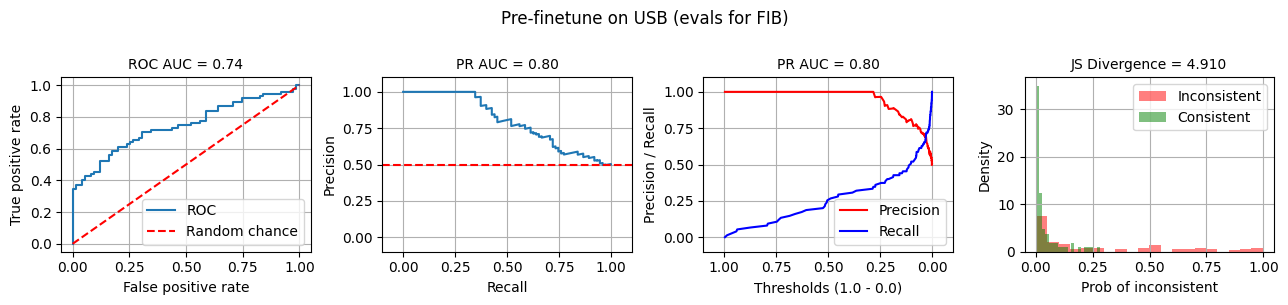

2024-08-05 00:52:54 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.90 - Recall: 0.07, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.80 - Recall: 0.08, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.75 - Recall: 0.11, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.70 - Recall: 0.15, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.65 - Recall: 0.17, Precision: 1.00
2024-08-05 00:52:54 - INFO - Threshold: 0.60 - Recall: 0.20, Precision: 1.00


In [26]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Pre-finetune on USB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

In [ ]:
# df = pd.DataFrame({'label': fib_val_labels, 'pred_proba': fib_val_preds})
# model_name = 'Pre-finetune (evals for FIB)'

# # Compute ROCAUC metrics
# rocauc = roc_auc_score(df['label'], df['pred_proba'])
# fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
# baseline = np.sum(df['label']) / len(df)

# # Compute PRAUC metrics
# prauc = average_precision_score(df['label'], df['pred_proba'])
# prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

# # Split into consistent and inconsistent for prob distribution
# inconsistent = df[df['label'] == 1].reset_index(drop=True)
# consistent = df[df['label'] == 0].reset_index(drop=True)
# js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

# # Set up plots
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(26, 6), tight_layout=True)
# title_font_size = 15
# fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

# # Plot ROC
# ax0.grid()
# ax0.plot(fpr, tpr, label='ROC')
# ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
# ax0.set_xlabel('False positive rate', fontsize=title_font_size)
# ax0.set_ylabel('True positive rate', fontsize=title_font_size)
# ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
# ax0.legend()

# # Plot PRAUC
# ax1.grid()
# ax1.plot(rec, prec, label='PRAUC')
# ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
# ax1.set_xlabel('Recall', fontsize=title_font_size)
# ax1.set_ylabel('Precision', fontsize=title_font_size)
# ax1.set_xlim((-0.1, 1.1))
# ax1.set_ylim((-0.1, 1.1))
# ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot Precision & Recall
# ax2.grid()
# ax2.plot(thresholds, prec[1:], color='red', label='Precision')
# ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
# ax2.invert_xaxis()
# ax2.set_xlabel('Thresholds (1.0 - 0.0)', fontsize=title_font_size)
# ax2.set_ylabel('Precision / Recall', fontsize=title_font_size)
# ax2.set_xlim((1.1, -0.1))
# ax2.set_ylim((-0.1, 1.1))
# ax2.legend()
# ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot prob distribution
# ax3.grid()
# ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.set_xlabel('Prob of inconsistent', fontsize=title_font_size)
# ax3.set_ylabel('Density', fontsize=title_font_size)
# ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
# ax3.legend()

# plt.show()

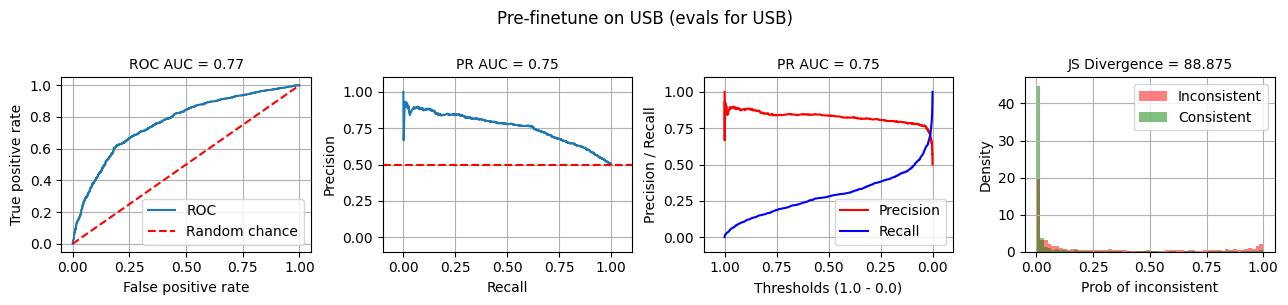

2024-08-05 00:53:55 - INFO - Threshold: 0.95 - Recall: 0.07, Precision: 0.89
2024-08-05 00:53:55 - INFO - Threshold: 0.90 - Recall: 0.11, Precision: 0.88
2024-08-05 00:53:55 - INFO - Threshold: 0.95 - Recall: 0.07, Precision: 0.89
2024-08-05 00:53:55 - INFO - Threshold: 0.80 - Recall: 0.16, Precision: 0.85
2024-08-05 00:53:55 - INFO - Threshold: 0.75 - Recall: 0.19, Precision: 0.84
2024-08-05 00:53:55 - INFO - Threshold: 0.70 - Recall: 0.21, Precision: 0.85
2024-08-05 00:53:55 - INFO - Threshold: 0.65 - Recall: 0.22, Precision: 0.84
2024-08-05 00:53:55 - INFO - Threshold: 0.60 - Recall: 0.25, Precision: 0.84


In [27]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Pre-finetune on USB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

## Start finetuning

## # Metrics from finetuning on FIB-only for comparison
```
Step    Training Loss   Fib Loss    Fib Prauc   Fib Rocauc  Fib Recall  Fib Precision
20      1.371500        0.854492    0.579853    0.579467    0.066667    0.714286
40      0.758200        0.713867    0.601021    0.604978    0.040000    0.750000
60      0.683100        0.681152    0.616764    0.632444    0.053333    0.800000
80      0.671600        0.668945    0.640852    0.648089    0.040000    0.750000
100     0.664400        0.662598    0.649766    0.658133    0.040000    0.750000
```

In [26]:
# USB first

trainer.train()

[2024-08-06 00:32:50,233] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2024-08-06 00:32:50 - INFO - gcc -pthread -B /root/miniconda3/envs/py3.11/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /root/miniconda3/envs/py3.11/include -fPIC -O2 -isystem /root/miniconda3/envs/py3.11/include -fPIC -c /tmp/tmp0f2weyxs/test.c -o /tmp/tmp0f2weyxs/test.o
2024-08-06 00:32:50 - INFO - gcc -pthread -B /root/miniconda3/envs/py3.11/compiler_compat /tmp/tmp0f2weyxs/test.o -laio -o /tmp/tmp0f2weyxs/a.out


 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.1), only 1.0.0 is known to be compatible


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
2024-08-06 00:33:37 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jermyn. Use `wandb login --relogin` to force relogin


2024-08-06 00:33:41 - INFO - Step 0 metrics: {'eval_usb_loss': 2.732421875, 'eval_usb_model_preparation_time': 0.0066, 'eval_usb_prauc': 0.754496531706082, 'eval_usb_rocauc': 0.765017229016676, 'eval_usb_recall': 0.1619190404797601, 'eval_usb_precision': 0.8503937007874016}
2024-08-06 00:33:43 - INFO - Step 0 metrics: {'eval_fib_loss': 2.013671875, 'eval_fib_model_preparation_time': 0.0066, 'eval_fib_prauc': 0.7990945640074882, 'eval_fib_rocauc': 0.7443555555555555, 'eval_fib_recall': 0.08, 'eval_fib_precision': 1.0}


Step,Training Loss,Validation Loss,Usb Loss,Usb Model Preparation Time,Usb Prauc,Usb Rocauc,Usb Recall,Usb Precision,Fib Loss,Fib Model Preparation Time,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
40,0.874700,No log,0.470215,0.006600,0.883619,0.876775,0.329085,0.954348,0.602539,0.006600,0.792691,0.768711,0.160000,1.000000
80,0.390900,No log,0.365967,0.006600,0.928789,0.923283,0.718141,0.914122,0.607422,0.006600,0.771776,0.781600,0.320000,0.800000
120,0.325000,No log,0.354248,0.006600,0.935336,0.929566,0.685907,0.932722,0.683105,0.006600,0.777696,0.776978,0.240000,0.857143
160,0.333200,No log,0.344971,0.006600,0.938197,0.933131,0.661169,0.943316,0.726074,0.006600,0.780811,0.773956,0.226667,0.944444
200,0.303900,No log,0.334717,0.006600,0.940585,0.935106,0.715142,0.932551,0.703125,0.006600,0.775114,0.768711,0.240000,0.900000


## Check evals after finetuning on USB

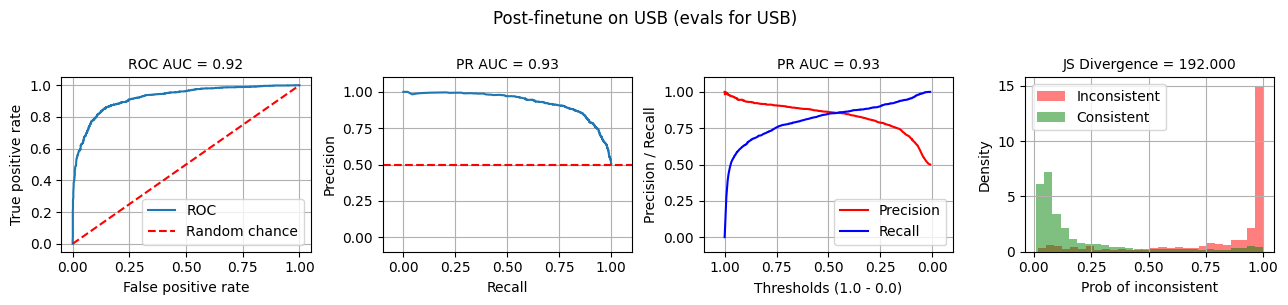

2024-08-06 00:50:55 - INFO - Threshold: 0.95 - Recall: 0.56, Precision: 0.96
2024-08-06 00:50:55 - INFO - Threshold: 0.90 - Recall: 0.64, Precision: 0.93
2024-08-06 00:50:55 - INFO - Threshold: 0.95 - Recall: 0.56, Precision: 0.96
2024-08-06 00:50:55 - INFO - Threshold: 0.80 - Recall: 0.72, Precision: 0.91
2024-08-06 00:50:55 - INFO - Threshold: 0.75 - Recall: 0.76, Precision: 0.91
2024-08-06 00:50:55 - INFO - Threshold: 0.70 - Recall: 0.78, Precision: 0.90
2024-08-06 00:50:55 - INFO - Threshold: 0.65 - Recall: 0.80, Precision: 0.89
2024-08-06 00:50:55 - INFO - Threshold: 0.60 - Recall: 0.81, Precision: 0.88


In [27]:
# Get predictions on USB
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Post-finetune on USB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

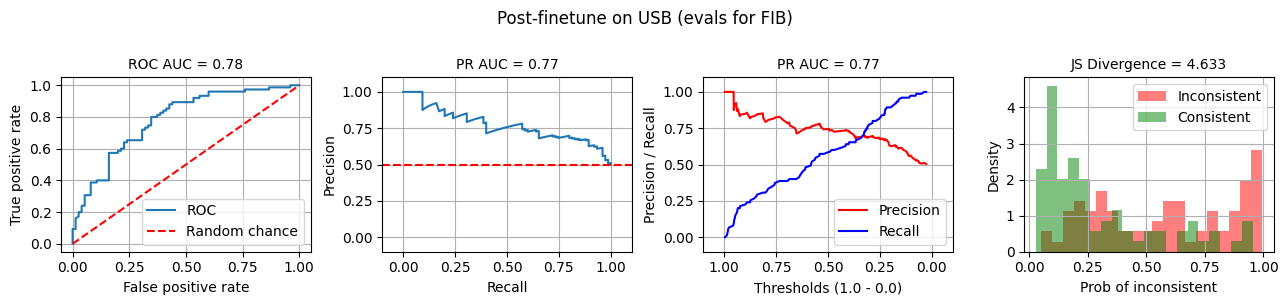

2024-08-06 00:50:58 - INFO - Threshold: 0.95 - Recall: 0.13, Precision: 0.91
2024-08-06 00:50:58 - INFO - Threshold: 0.90 - Recall: 0.23, Precision: 0.85
2024-08-06 00:50:58 - INFO - Threshold: 0.95 - Recall: 0.13, Precision: 0.91
2024-08-06 00:50:58 - INFO - Threshold: 0.80 - Recall: 0.32, Precision: 0.80
2024-08-06 00:50:58 - INFO - Threshold: 0.75 - Recall: 0.39, Precision: 0.83
2024-08-06 00:50:58 - INFO - Threshold: 0.70 - Recall: 0.39, Precision: 0.78
2024-08-06 00:50:58 - INFO - Threshold: 0.65 - Recall: 0.41, Precision: 0.72
2024-08-06 00:50:58 - INFO - Threshold: 0.60 - Recall: 0.49, Precision: 0.76


In [28]:
# Get predictions on FIB
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Post-finetune on USB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

## Next, set up trainer to finetune on FIB data
- FIB contains one-sentence summaries on CNN/DM & XSUM news articles.
- Note: We exclude the CNN/Daily Mail data is pretty bad.
- https://huggingface.co/datasets/r-three/fib

In [29]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=10  # 10
EVAL_STEPS=25
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [30]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='./checkpoints/bart-usb-fib',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    evaluation_strategy='steps',
    eval_steps=EVAL_STEPS,  # Update eval steps to reduce time spent on evals
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='fib_recall',
    greater_is_better=True,
    load_best_model_at_end=True,
)

/root/miniconda3/envs/py3.11/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=fib_ds['train'],
    eval_dataset={'usb': usb_ds['val'], 'fib': fib_ds['val']},  # Custom trainer supports two eval datasets!
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    eval_before_train=True)

# # Metrics from finetuning on FIB-only for comparison
```
Step    Training Loss   Fib Loss    Fib Prauc   Fib Rocauc  Fib Recall  Fib Precision
20      1.371500        0.854492    0.579853    0.579467    0.066667    0.714286
40      0.758200        0.713867    0.601021    0.604978    0.040000    0.750000
60      0.683100        0.681152    0.616764    0.632444    0.053333    0.800000
80      0.671600        0.668945    0.640852    0.648089    0.040000    0.750000
100     0.664400        0.662598    0.649766    0.658133    0.040000    0.750000
```

In [32]:
trainer.train()

2024-08-06 00:52:25 - INFO - Step 0 metrics: {'eval_usb_loss': 0.365966796875, 'eval_usb_model_preparation_time': 0.0088, 'eval_usb_prauc': 0.9287892136375684, 'eval_usb_rocauc': 0.9232828300991932, 'eval_usb_recall': 0.7181409295352323, 'eval_usb_precision': 0.9141221374045801}
2024-08-06 00:52:28 - INFO - Step 0 metrics: {'eval_fib_loss': 0.607421875, 'eval_fib_model_preparation_time': 0.0088, 'eval_fib_prauc': 0.7717755151261524, 'eval_fib_rocauc': 0.7816000000000001, 'eval_fib_recall': 0.32, 'eval_fib_precision': 0.8}


Step,Training Loss,Validation Loss,Usb Loss,Usb Model Preparation Time,Usb Prauc,Usb Rocauc,Usb Recall,Usb Precision,Fib Loss,Fib Model Preparation Time,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
25,0.540200,No log,0.369873,0.008800,0.927039,0.920378,0.715892,0.917387,0.484619,0.008800,0.854540,0.850933,0.506667,0.883721
50,0.421000,No log,0.399902,0.008800,0.921872,0.913638,0.742129,0.895928,0.457764,0.008800,0.879963,0.869689,0.573333,0.877551
75,0.354900,No log,0.420166,0.008800,0.920112,0.910799,0.747376,0.884650,0.445557,0.008800,0.889604,0.880622,0.586667,0.880000
100,0.303800,No log,0.435059,0.008800,0.919528,0.909863,0.757871,0.879130,0.446533,0.008800,0.894935,0.886400,0.640000,0.888889


In [ ]:
# REFERENCE

trainer.train()

2024-05-11 22:43:46 - INFO - Step 0 metrics: {'eval_usb_loss': 0.336669921875, 'eval_usb_prauc': 0.9458174724898825, 'eval_usb_rocauc': 0.9399249026161584, 'eval_usb_recall': 0.7886056971514243, 'eval_usb_precision': 0.9187772925764193}
2024-05-11 22:43:49 - INFO - Step 0 metrics: {'eval_fib_loss': 0.7568359375, 'eval_fib_prauc': 0.6580583088395531, 'eval_fib_rocauc': 0.6432, 'eval_fib_recall': 0.25333333333333335, 'eval_fib_precision': 0.7307692307692307}


Step,Training Loss,Validation Loss,Usb Loss,Usb Prauc,Usb Rocauc,Usb Recall,Usb Precision,Fib Loss,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
20,0.650600,No log,0.503418,0.938988,0.934167,0.894303,0.821625,0.598633,0.740828,0.756800,0.293333,0.880000
40,0.540700,No log,0.544434,0.930835,0.926803,0.902549,0.809684,0.517578,0.819064,0.826844,0.426667,0.914286
60,0.452400,No log,0.502441,0.924939,0.921494,0.865817,0.830338,0.481689,0.857859,0.848356,0.440000,0.942857
80,0.424500,No log,0.519531,0.922597,0.919200,0.868066,0.821277,0.472412,0.868118,0.853067,0.480000,0.923077
100,0.399700,No log,0.563965,0.919798,0.916684,0.876312,0.802334,0.464844,0.874490,0.861689,0.573333,0.934783


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

## Check evals after finetuning on USB followed by FIB

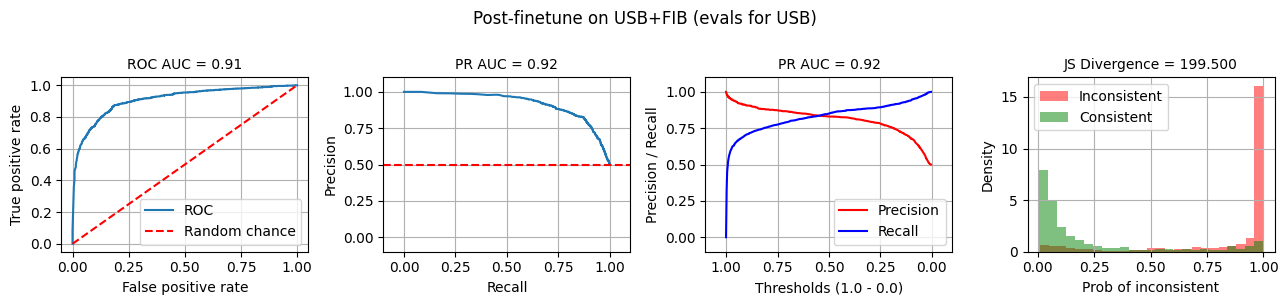

2024-08-06 01:04:10 - INFO - Threshold: 0.95 - Recall: 0.65, Precision: 0.93
2024-08-06 01:04:10 - INFO - Threshold: 0.90 - Recall: 0.71, Precision: 0.91
2024-08-06 01:04:10 - INFO - Threshold: 0.95 - Recall: 0.65, Precision: 0.93
2024-08-06 01:04:10 - INFO - Threshold: 0.80 - Recall: 0.76, Precision: 0.88
2024-08-06 01:04:10 - INFO - Threshold: 0.75 - Recall: 0.77, Precision: 0.87
2024-08-06 01:04:10 - INFO - Threshold: 0.70 - Recall: 0.79, Precision: 0.87
2024-08-06 01:04:10 - INFO - Threshold: 0.65 - Recall: 0.81, Precision: 0.85
2024-08-06 01:04:10 - INFO - Threshold: 0.60 - Recall: 0.82, Precision: 0.85


In [33]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Post-finetune on USB+FIB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

In [34]:
def eval_fib(dataset, split='val'):
    # Get predictions
    fib_preds = trainer.predict(fib_ds[split])[0]

    # Get labels and update them so entailment = 0 and contradiction = 1
    fib_labels = np.array(fib_ds[split]['label'])
    fib_labels = np.where(fib_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    visualize_preds(fib_labels, fib_preds, f'Post-finetune on USB+FIB training data ({split})')
    compute_metrics_per_threshold(fib_labels, fib_preds)

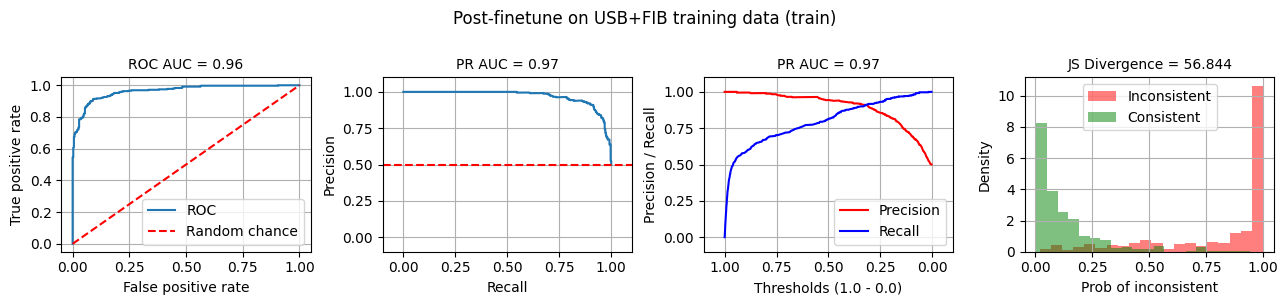

2024-08-06 01:04:23 - INFO - Threshold: 0.95 - Recall: 0.52, Precision: 1.00
2024-08-06 01:04:23 - INFO - Threshold: 0.90 - Recall: 0.59, Precision: 1.00
2024-08-06 01:04:23 - INFO - Threshold: 0.95 - Recall: 0.52, Precision: 1.00
2024-08-06 01:04:23 - INFO - Threshold: 0.80 - Recall: 0.68, Precision: 0.99
2024-08-06 01:04:23 - INFO - Threshold: 0.75 - Recall: 0.70, Precision: 0.98
2024-08-06 01:04:23 - INFO - Threshold: 0.70 - Recall: 0.72, Precision: 0.97
2024-08-06 01:04:23 - INFO - Threshold: 0.65 - Recall: 0.75, Precision: 0.96
2024-08-06 01:04:23 - INFO - Threshold: 0.60 - Recall: 0.77, Precision: 0.96


In [35]:
eval_fib(fib_ds, 'train')

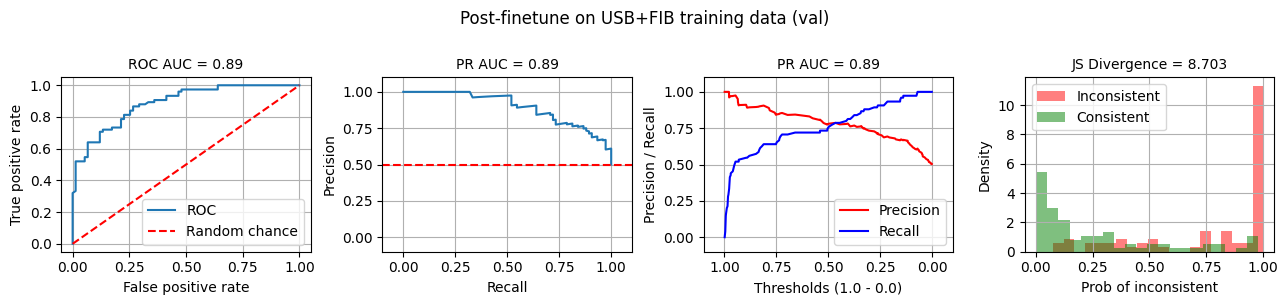

2024-08-06 01:04:26 - INFO - Threshold: 0.95 - Recall: 0.52, Precision: 0.97
2024-08-06 01:04:26 - INFO - Threshold: 0.90 - Recall: 0.55, Precision: 0.91
2024-08-06 01:04:26 - INFO - Threshold: 0.95 - Recall: 0.52, Precision: 0.97
2024-08-06 01:04:26 - INFO - Threshold: 0.80 - Recall: 0.64, Precision: 0.89
2024-08-06 01:04:26 - INFO - Threshold: 0.75 - Recall: 0.65, Precision: 0.84
2024-08-06 01:04:26 - INFO - Threshold: 0.70 - Recall: 0.71, Precision: 0.84
2024-08-06 01:04:26 - INFO - Threshold: 0.65 - Recall: 0.72, Precision: 0.83
2024-08-06 01:04:26 - INFO - Threshold: 0.60 - Recall: 0.72, Precision: 0.83


In [36]:
eval_fib(fib_ds, 'val')

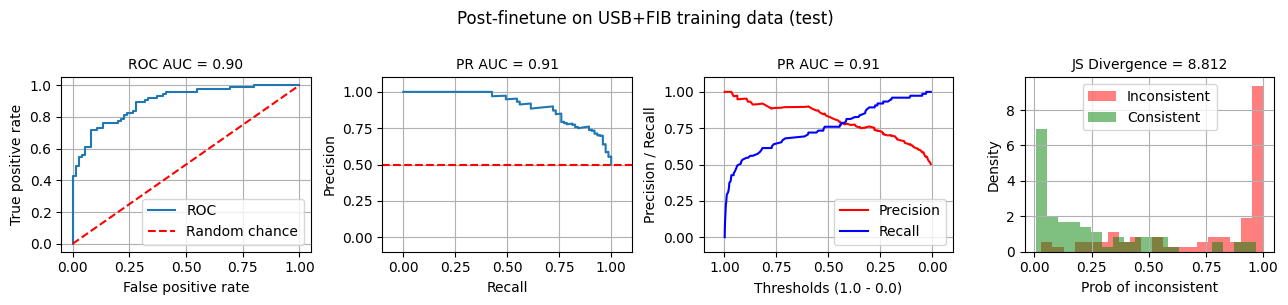

2024-08-06 01:04:29 - INFO - Threshold: 0.95 - Recall: 0.45, Precision: 0.97
2024-08-06 01:04:29 - INFO - Threshold: 0.90 - Recall: 0.55, Precision: 0.95
2024-08-06 01:04:29 - INFO - Threshold: 0.95 - Recall: 0.45, Precision: 0.97
2024-08-06 01:04:29 - INFO - Threshold: 0.80 - Recall: 0.61, Precision: 0.90
2024-08-06 01:04:29 - INFO - Threshold: 0.75 - Recall: 0.65, Precision: 0.89
2024-08-06 01:04:29 - INFO - Threshold: 0.70 - Recall: 0.69, Precision: 0.90
2024-08-06 01:04:29 - INFO - Threshold: 0.65 - Recall: 0.69, Precision: 0.90
2024-08-06 01:04:29 - INFO - Threshold: 0.60 - Recall: 0.71, Precision: 0.90


In [37]:
eval_fib(fib_ds, 'test')

In [ ]:
# df = pd.DataFrame({'label': fib_val_labels, 'pred_proba': fib_val_preds})
# model_name = 'Post-finetune on USB+FIB (evals for FIB)'

# # Compute ROCAUC metrics
# rocauc = roc_auc_score(df['label'], df['pred_proba'])
# fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
# baseline = np.sum(df['label']) / len(df)

# # Compute PRAUC metrics
# prauc = average_precision_score(df['label'], df['pred_proba'])
# prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

# # Split into consistent and inconsistent for prob distribution
# inconsistent = df[df['label'] == 1].reset_index(drop=True)
# consistent = df[df['label'] == 0].reset_index(drop=True)
# js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

# # Set up plots
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(26, 6), tight_layout=True)
# title_font_size = 15
# fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

# # Plot ROC
# ax0.grid()
# ax0.plot(fpr, tpr, label='ROC')
# ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
# ax0.set_xlabel('False positive rate', fontsize=title_font_size)
# ax0.set_ylabel('True positive rate', fontsize=title_font_size)
# ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
# ax0.legend()

# # Plot PRAUC
# ax1.grid()
# ax1.plot(rec, prec, label='PRAUC')
# ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
# ax1.set_xlabel('Recall', fontsize=title_font_size)
# ax1.set_ylabel('Precision', fontsize=title_font_size)
# ax1.set_xlim((-0.1, 1.1))
# ax1.set_ylim((-0.1, 1.1))
# ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot Precision & Recall
# ax2.grid()
# ax2.plot(thresholds, prec[1:], color='red', label='Precision')
# ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
# ax2.invert_xaxis()
# ax2.set_xlabel('Thresholds (1.0 - 0.0)', fontsize=title_font_size)
# ax2.set_ylabel('Precision / Recall', fontsize=title_font_size)
# ax2.set_xlim((1.1, -0.1))
# ax2.set_ylim((-0.1, 1.1))
# ax2.legend()
# ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

# # Plot prob distribution
# ax3.grid()
# ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
# ax3.set_xlabel('Prob of inconsistent', fontsize=title_font_size)
# ax3.set_ylabel('Density', fontsize=title_font_size)
# ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
# ax3.legend()

# plt.show()

In [38]:
# for notebooks
import wandb

wandb.finish()

eval/fib_loss,██▂▂▂▂▂▂▂▁▁▁▁
eval/fib_model_preparation_time,▁▁▁▁▁▁▁██████
eval/fib_prauc,▃▃▂▁▁▂▁▁▁▆▇██
eval/fib_precision,███▁▃▆▄▁▁▄▄▄▄
eval/fib_recall,▁▁▂▄▃▃▃▄▄▆▇▇█
eval/fib_rocauc,▁▁▂▃▃▂▂▃▃▆▇██
eval/usb_loss,██▁▁▁▁▁▁▁▁▁▁▁
eval/usb_model_preparation_time,▁▁▁▁▁▁▁██████
eval/usb_prauc,▁▁▆██████▇▇▇▇
eval/usb_precision,▁▁█▅▇▇▇▅▅▆▄▃▃
eval/usb_recall,▁▁▃█▇▇▇██████


# Fin

Now go finetune and eval your own models